# Import libraries and modules

In [11]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from LSTM_module import StockLSTM
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [13]:
import sys
import os

module_path = os.path.abspath(os.path.join('../Datasets'))
if module_path not in sys.path:
    sys.path.append(module_path)

from dataset_creation import StockDataset

# Load Dataset

In [12]:
base_path = "../price/raw"
df = pd.read_csv(f"{base_path}/AAPL.csv")
print(len(df))

1258


In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-09-04,95.108574,96.448570,94.928574,96.424286,87.121140,91973000
1,2012-09-05,96.510002,96.621429,95.657143,95.747147,86.509338,84093800
2,2012-09-06,96.167145,96.898575,95.828575,96.610001,87.288956,97799100
3,2012-09-07,96.864288,97.497147,96.538574,97.205711,87.827171,82416600
4,2012-09-10,97.207146,97.612854,94.585716,94.677139,85.542564,121999500


In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[['Open','High','Low','Close','Volume']] = scaler.fit_transform(df[['Open','High','Low','Close','Volume']])

In [16]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-09-04,0.362825,0.364963,0.367482,0.375340,87.121140,0.227562
1,2012-09-05,0.375638,0.366566,0.374189,0.369085,86.509338,0.205288
2,2012-09-06,0.372504,0.369136,0.375768,0.377055,87.288956,0.244032
3,2012-09-07,0.378878,0.374685,0.382305,0.382558,87.827171,0.200546
4,2012-09-10,0.382012,0.375758,0.364325,0.359201,85.542564,0.312446


# Prepare dataset

In [54]:
feature_columns = ['Open','High','Low','Close','Volume']
# feature_columns = ['Close']
filtered_df = df[feature_columns]
seq_len = 10
train_size = int(len(filtered_df) * 0.8)
train_data = filtered_df.iloc[:train_size]
test_data = filtered_df.iloc[train_size:]


In [55]:
try:
    train_dataset = StockDataset(train_data, seq_len, feature_columns)
    test_dataset = StockDataset(test_data, seq_len, feature_columns)
    print("Datasets created successfully!")
except Exception as e:
    print(f"Error creating dataset: {e}")

Datasets created successfully!


In [56]:
train_dataset[0]

(tensor([[0.3628, 0.3650, 0.3675, 0.3753, 0.2276],
         [0.3756, 0.3666, 0.3742, 0.3691, 0.2053],
         [0.3725, 0.3691, 0.3758, 0.3771, 0.2440],
         [0.3789, 0.3747, 0.3823, 0.3826, 0.2005],
         [0.3820, 0.3758, 0.3643, 0.3592, 0.3124],
         [0.3620, 0.3583, 0.3570, 0.3564, 0.3237],
         [0.3642, 0.3580, 0.3563, 0.3685, 0.4709],
         [0.3780, 0.3787, 0.3810, 0.3859, 0.3904],
         [0.3944, 0.3939, 0.3982, 0.3969, 0.3919],
         [0.4067, 0.3976, 0.4071, 0.4081, 0.2489]]),
 tensor(0.4109))

In [57]:
# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



# Model initialization

In [61]:
input_size = len(feature_columns)
hidden_size = 128
num_layers = 3

model = StockLSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [62]:
epochs = 100
for epoch in range(epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

# Test the model
model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        predictions.extend(outputs.squeeze().numpy())
        actuals.extend(targets.numpy())

Epoch 1/100, Loss: 0.009803221561014652
Epoch 2/100, Loss: 0.04910356178879738
Epoch 3/100, Loss: 0.007827581837773323
Epoch 4/100, Loss: 0.0010483748046681285
Epoch 5/100, Loss: 0.001675026724115014
Epoch 6/100, Loss: 0.0013278003316372633
Epoch 7/100, Loss: 0.0021231435239315033
Epoch 8/100, Loss: 0.0019446334335952997
Epoch 9/100, Loss: 0.001371200429275632
Epoch 10/100, Loss: 0.0005668331868946552
Epoch 11/100, Loss: 0.0007176247891038656
Epoch 12/100, Loss: 0.0003044525219593197
Epoch 13/100, Loss: 0.0009182590874843299
Epoch 14/100, Loss: 0.0007298466516658664
Epoch 15/100, Loss: 0.0005348121630959213
Epoch 16/100, Loss: 0.0004329335642978549
Epoch 17/100, Loss: 0.00028408155776560307
Epoch 18/100, Loss: 0.0011382353259250522
Epoch 19/100, Loss: 0.0006140489131212234
Epoch 20/100, Loss: 0.0002845781564246863
Epoch 21/100, Loss: 0.00046018086140975356
Epoch 22/100, Loss: 0.0006997259333729744
Epoch 23/100, Loss: 0.0003759765240829438
Epoch 24/100, Loss: 0.00023448547290172428
Epoc

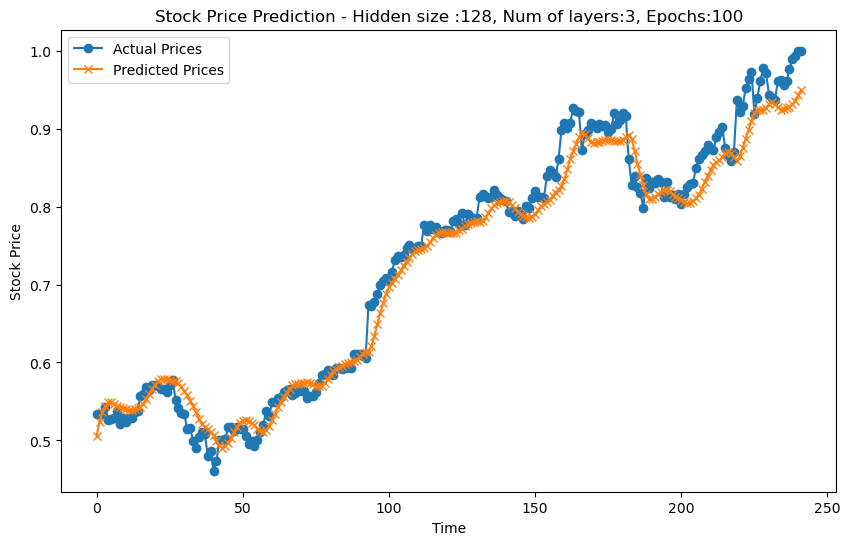

In [63]:
# Visualize results
plt.figure(figsize=(10, 6))
plt.plot(actuals, label='Actual Prices', marker='o')
plt.plot(predictions, label='Predicted Prices', marker='x')
plt.title(f'Stock Price Prediction - Hidden size :{hidden_size}, Num of layers:{ num_layers}, Epochs:{epochs}')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
